# Process DocuScope output

## Load cluster counts

In [1]:
# Load category counts
import pandas as pd

csvpath = '/storage2/mamille3/data/hate_speech/degibert2019/docuscope_output/sentences-2022-02-16-212529/csv/CLUSTER_C_sentences.csv'
category_counts = pd.read_csv(csvpath, index_col=0)
category_counts.index = category_counts.index.str.slice(0,-4)
category_counts
len(category_counts.columns)

old_cols = category_counts.columns

# Drop categories that do not occur
category_counts = category_counts.loc[:, (category_counts != 0).any(axis=0)] # Is just one category
len(category_counts.columns)

# Show categories that didn't occur
new_cols = category_counts.columns
print(set(old_cols) - set(new_cols))

# Load sentence splits and annotations
annotations_fpath = '/storage2/mamille3/data/hate_speech/degibert2019/combined_data.csv'
annotations = pd.read_csv(annotations_fpath).sort_values(['comment_id', 'sentence_id']).set_index('file_id')
annotations

# Merge DocuScope output with labels, metadata
merged = pd.merge(annotations, category_counts, left_index=True, right_index=True)
merged

{'InquiryPositive'}


,comment_id,sentence_id,text,user_id,subforum_id,num_contexts,label,Tokens,AcademicTerms,AcademicWritingMoves,...,ResponsiblityNegative,ResponsiblityPositive,Strategic,StrategicNegative,StrategicPositive,Uncertainty,Updates,UpdatesNegative,UpdatesPositive,Group
12834217_1,12834217,1,"As of March 13th , 2014 , the booklet had been...",572066,1346,0,noHate,18,1,0,...,0,0,0,0,0,0,0,0,0,NaN
12834217_2,12834217,2,In order to help increase the booklets downloa...,572066,1346,0,noHate,36,1,0,...,0,0,1,0,0,0,0,0,0,NaN
12834217_3,12834217,3,( Simply copy and paste the following text int...,572066,1346,0,noHate,16,1,0,...,0,0,0,0,0,0,0,0,0,NaN
12834217_4,12834217,4,Click below for a FREE download of a colorfull...,572066,1346,0,hate,22,1,0,...,0,0,0,0,0,0,0,0,0,NaN
12834217_5,12834217,5,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,572066,1346,0,noHate,22,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33677015_1,33677015,1,Apparently he came to the conclusion that his ...,572948,1388,0,noHate,25,0,0,...,0,0,0,0,0,0,0,0,0,NaN
33677019_1,33677019,1,Wish we at least had a Marine Le Pen to vote f...,735154,1388,0,noHate,15,0,0,...,0,0,1,0,0,0,0,0,0,NaN
33677019_2,33677019,2,Its like the choices are white genocide candid...,735154,1388,0,noHate,14,0,0,...,0,0,0,0,0,0,0,0,0,NaN
33677053_1,33677053,1,Why White people used to say that sex was a si...,572266,1388,0,hate,35,2,0,...,0,0,0,0,0,0,0,0,0,NaN


## Visualize DocuScope categories hate/nonhate

In [12]:
# Group by hate/nonhate
gps = merged.groupby('label').sum()
gps

# Normalize by token length
for col in gps.columns[6:]:
    gps[f'mean_{col}'] = gps[col]/gps['Tokens']
gps.loc[:, ['Tokens', 'AcademicTerms', 'mean_AcademicTerms']]

# Select categories with the biggest discrepancy between hate/nonhate
selected = gps.loc[['hate', 'noHate'], :]
selected

diffs = selected.loc['hate'] - selected.loc['noHate']
mean_diffs = diffs[[col for col in diffs.index if col.startswith('mean')]]
mean_diffs.sort_values(ascending=False)

# Plot top categories with the biggest discrepancies between hate and non-hate
topn = 10
top_cats = mean_diffs.sort_values(ascending=False)[:topn]
top_cats

top = selected[top_cats.index]
top

# Change to long-form df (not actually necessary, but whatever)
long_top = pd.melt(top, id_vars=[], value_vars=top.columns, var_name='category', value_name='normalized_count', ignore_index=False).reset_index()
long_top['category'] = long_top.category.str.slice(5)
long_top

,label,category,normalized_count
0,hate,Negative,0.048204
1,noHate,Negative,0.029405
2,hate,CharacterTraitsTypes,0.039841
3,noHate,CharacterTraitsTypes,0.028918
4,hate,Description,0.064495
5,noHate,Description,0.059332
6,hate,Reasoning,0.008296
7,noHate,Reasoning,0.005356
8,hate,Future,0.005988
9,noHate,Future,0.003758


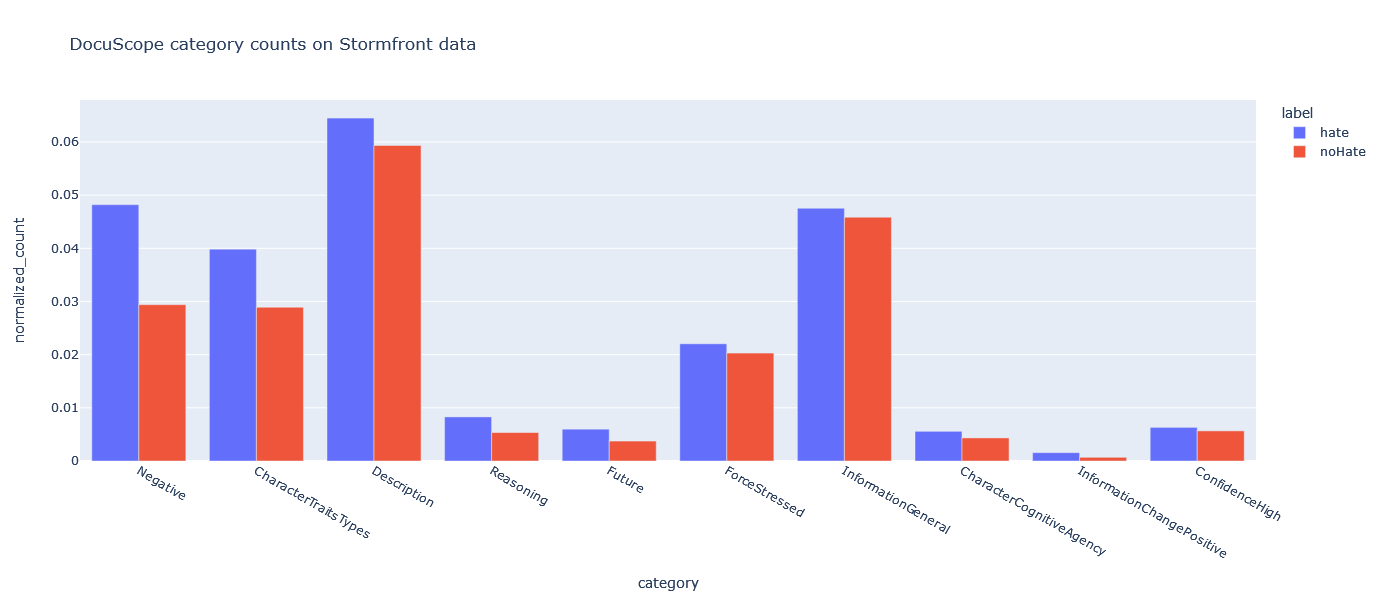

In [13]:
# Plot bar graph
import plotly.express as px
fig = px.bar(long_top, x='category', y='normalized_count', color='label', title='DocuScope category counts on Stormfront data', barmode='group', height=600, width=800)
fig.show()

# Old

## Dealing with the token CSVs
But they just give LATs, not clusters :(((

In [8]:
# Load token csvs
import os
import pandas as pd

ds_output_dirpath = '/storage2/mamille3/data/hate_speech/degibert2019/docuscope_output_by_author/degibert2019_by_author-2022-02-15-141033/'
for fname in os.listdir(os.path.join(ds_output_dirpath, 'token_csv'))[:1]:
    print(fname)
    fpath = os.path.join(ds_output_dirpath, 'token_csv', fname)
    tokens = pd.read_csv(fpath, names=['original_token', 'lowercased_token', 'whitespace_after', 'lat', 'pattern_position'])
    
tokens

577938_tokens.csv


,original_token,lowercased_token,whitespace_after,lat,pattern_position
0,GLORY,glory,s,PositiveValuesDimensionGeneral_LAT,0
1,To,to,s,PositiveRelationsInclusive_LAT,0
2,our,our,s,PositiveRelationsInclusive_LAT,1
3,British,british,s,CharacterTypesDimensionGeneral_LAT,0
4,Activist,activist,s,StrategicActivismDimensionGeneral_LAT,0
5,&,&,s,NaN,0
6,Nationalist,nationalist,s,PublicDimensionGeneral_LAT,0
7,!,!,s,ForceDimensionGeneral_LAT,0
8,Good,good,s,PositiveEmotionGood_LAT,0
9,To,to,s,PositiveEmotionGood_LAT,1


In [13]:
# Load sentence splits and annotations
annotations_fpath = '/storage2/mamille3/data/hate_speech/degibert2019/combined_data.csv'
annotations = pd.read_csv(annotations_fpath).sort_values(['comment_id', 'sentence_id']).set_index('file_id')
annotations

,comment_id,sentence_id,text,user_id,subforum_id,num_contexts,label
file_id,,,,,,,
12834217_1,12834217,1,"As of March 13th , 2014 , the booklet had been...",572066,1346,0,noHate
12834217_2,12834217,2,In order to help increase the booklets downloa...,572066,1346,0,noHate
12834217_3,12834217,3,( Simply copy and paste the following text int...,572066,1346,0,noHate
12834217_4,12834217,4,Click below for a FREE download of a colorfull...,572066,1346,0,hate
12834217_5,12834217,5,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,572066,1346,0,noHate
...,...,...,...,...,...,...,...
33677015_1,33677015,1,Apparently he came to the conclusion that his ...,572948,1388,0,noHate
33677019_1,33677019,1,Wish we at least had a Marine Le Pen to vote f...,735154,1388,0,noHate
33677019_2,33677019,2,Its like the choices are white genocide candid...,735154,1388,0,noHate


In [28]:
# Select user data
selected_user = int(fname.split('_')[0])
user_annotations = annotations.query('user_id == @selected_user').copy()
user_annotations['sentence_length'] = [len(x) for x in user_annotations.text.str.split()]
user_annotations

,comment_id,sentence_id,text,user_id,subforum_id,num_contexts,label,sentence_length
file_id,,,,,,,,
30430878_1,30430878,1,GLORY To our British Activist & Nationalist ! ...,577938,1359,0,noHate,17
30430878_2,30430878,2,Glory To all our Valiant British Brothers & Si...,577938,1359,0,noHate,10


In [29]:
# Explode to tokens
s = user_annotations.text.str.split().apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'original_token'
del user_annotations['text']
merged = user_annotations.join(s)
token_annotations = merged.reset_index()
token_annotations

In [30]:
token_data = pd.concat([token_annotations, tokens], axis=1)
token_data = token_data.loc[:, ~token_data.columns.duplicated()]
token_data

,file_id,comment_id,sentence_id,user_id,subforum_id,num_contexts,label,sentence_length,original_token,lowercased_token,whitespace_after,lat,pattern_position
0,30430878_1,30430878,1,577938,1359,0,noHate,17,GLORY,glory,s,PositiveValuesDimensionGeneral_LAT,0
1,30430878_1,30430878,1,577938,1359,0,noHate,17,To,to,s,PositiveRelationsInclusive_LAT,0
2,30430878_1,30430878,1,577938,1359,0,noHate,17,our,our,s,PositiveRelationsInclusive_LAT,1
3,30430878_1,30430878,1,577938,1359,0,noHate,17,British,british,s,CharacterTypesDimensionGeneral_LAT,0
4,30430878_1,30430878,1,577938,1359,0,noHate,17,Activist,activist,s,StrategicActivismDimensionGeneral_LAT,0
5,30430878_1,30430878,1,577938,1359,0,noHate,17,&,&,s,NaN,0
6,30430878_1,30430878,1,577938,1359,0,noHate,17,Nationalist,nationalist,s,PublicDimensionGeneral_LAT,0
7,30430878_1,30430878,1,577938,1359,0,noHate,17,!,!,s,ForceDimensionGeneral_LAT,0
8,30430878_1,30430878,1,577938,1359,0,noHate,17,Good,good,s,PositiveEmotionGood_LAT,0
9,30430878_1,30430878,1,577938,1359,0,noHate,17,To,to,s,PositiveEmotionGood_LAT,1


## Get cluster counts per sentence
Wait, but token CSVs just have LATs, not clusters

In [31]:
# Remove multiword labels (just count them once)
processed = token_data.query('pattern_position == 0')

# Get dummy variables for each column value
processed.pivot_table(index=['file_id'], columns=['lat'])

comment_id  \
lat        CharacterTypesDimensionGeneral_LAT   
file_id                                         
30430878_1                         30430878.0   
30430878_2                         30430878.0   

                                                               \
lat        DescriptObjectsDimensionGeneralWarehouseAThruZ_LAT   
file_id                                                         
30430878_1                                         30430878.0   
30430878_2                                                NaN   

                                                                   \
lat        ForceDimensionGeneral_LAT OrphanedDimensionGeneral_LAT   
file_id                                                             
30430878_1                30430878.0                   30430878.0   
30430878_2                30430878.0                          NaN   

                                                        \
lat        PositiveActHelp_LAT PositiveEmotionGood_LAT   
file_id                                                  
30430878_1          30430878.0              30430878.0   
30430878_2                 NaN                     NaN   

                                                                              \
lat        PositiveRelationsInclusive_LAT PositiveValuesDimensionGeneral_LAT   
file_id                                                                        
30430878_1                     30430878.0                         30430878.0   
30430878_2                     30430878.0                         30430878.0   

                                                                ...  \
lat        PositiveValuesStrong_LAT PublicDimensionGeneral_LAT  ...   
file_id                                                         ...   
30430878_1                      NaN                 30430878.0  ...   
30430878_2               30430878.0                        NaN  ...   

                                user_id                      \
lat        OrphanedDimensionGeneral_LAT PositiveActHelp_LAT   
file_id                                                       
30430878_1                     577938.0            577938.0   
30430878_2                          NaN                 NaN   

                                                                   \
lat        PositiveEmotionGood_LAT PositiveRelationsInclusive_LAT   
file_id                                                             
30430878_1                577938.0                       577938.0   
30430878_2                     NaN                       577938.0   

                                                                        \
lat        PositiveValuesDimensionGeneral_LAT PositiveValuesStrong_LAT   
file_id                                                                  
30430878_1                           577938.0                      NaN   
30430878_2                           577938.0                 577938.0   

                                                                   \
lat        PublicDimensionGeneral_LAT ReasonGenericGeneralize_LAT   
file_id                                                             
30430878_1                   577938.0                         NaN   
30430878_2                        NaN                    577938.0   

                                                  \
lat        StrategicActivismDimensionGeneral_LAT   
file_id                                            
30430878_1                              577938.0   
30430878_2                                   NaN   

                                               
lat        StrategicGoalsDimensionGeneral_LAT  
file_id                                        
30430878_1                           577938.0  
30430878_2                                NaN  

[2 rows x 91 columns]